In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Query Date:  2016-08-26


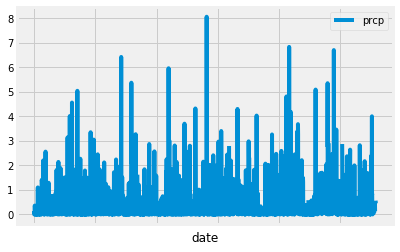

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
date_str = "17"
session.query(Measurement.date).\
   filter(func.strftime("%m", Measurement.date) == date_str).all()

# Calculate the date 1 year ago from the last data point in the database

#session.query(Measurement.date).order_by(Measurement.date.desc()).first()
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=362)
print("Query Date: ", query_date)

# Perform a query to retrieve the date and precipitation scores
date_prcp = session.query(Measurement.date, Measurement.prcp).group_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.DataFrame(date_prcp, columns=['date', 'prcp']) 
measurement_df.set_index(['date'], inplace=True)
measurement_df.head()


# Sort the dataframe by date
sorted_df = measurement_df.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data
sorted_df.plot(x_compat=True)

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurement_df.describe()

,prcp
count,2659.000000
mean,0.404735
std,0.696393
min,0.000000
25%,0.010000
50%,0.130000
75%,0.510000
max,8.060000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()


9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.id, Measurement.station,  func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()



[(14959, 'USC00519281', 2772),
 (2724, 'USC00519397', 2724),
 (5433, 'USC00513117', 2709),
 (12187, 'USC00519523', 2669),
 (19550, 'USC00516128', 2612),
 (7635, 'USC00514830', 2202),
 (16938, 'USC00511918', 1979),
 (9007, 'USC00517948', 1372),
 (9518, 'USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

KeyboardInterrupt: 

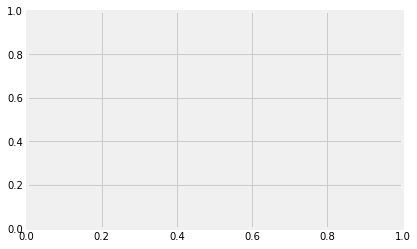

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
high_temp_query = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.station >= query_date).all()
  

plt.hist(high_temp_query, bins=12)
plt.tight_layout()

![precipitation](Images/station-histogram.png)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
begin_trip = dt.date(2017, 7, 29) - dt.timedelta(days=362)
end_trip = dt.date(2017, 8, 3) - dt.timedelta(days=362)

trip_temps = calc_temps(begin_trip, end_trip)

print(trip_temps) 

[(72.0, 77.63157894736842, 82.0)]


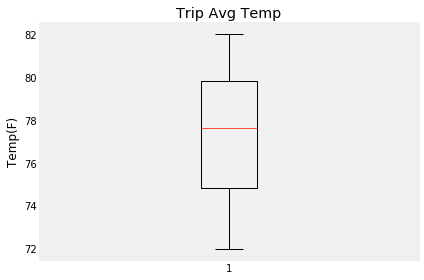

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmax=func.max(Measurement.tobs)
tmin=func.min(Measurement.tobs)
tmax_tmin = func.max(Measurement.tobs)-func.min(Measurement.tobs)

plt.boxplot(trip_temps)
plt.title("Trip Avg Temp")
plt.ylabel("Temp(F)")
#plt.errorbar(tmax, tmin, yerr=tmax_tmin, fmt="o")
plt.tight_layout()
plt.grid()
plt.show()

In [33]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp).\
    filter(Measurement.date == '2016, 8, 1').\
    filter(Measurement.date == '2016, 8, 6').\
    group_by(Station.station).\
    order_by(Measurement.prcp.desc()).all()
trip_rainfall

[]

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [35]:
# Plot the daily normals as an area plot with `stacked=False`
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [36]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [37]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [ ]:
#date_prcp = session.query(Measurement.date, Measurement.prcp).group_by(Measurement.date).all()
#date_prcp

In [27]:
measurement_df = pd.DataFrame(date_prcp, columns=['date', 'prcp']) 
measurement_df.set_index('date', inplace=True)
measurement_df.head()




,prcp
date,
2010-01-01,0.14
2010-01-02,0.00
2010-01-03,0.00
2010-01-04,0.00
2010-01-05,0.00


In [28]:
#sorted_df = measurement_df.sort_values(by=['date'])

sorted_df = measurement_df.sort_index()
sorted_df

,prcp
date,
2010-01-01,0.14
2010-01-02,0.00
2010-01-03,0.00
2010-01-04,0.00
2010-01-05,0.00
2010-01-06,0.36
2010-01-07,0.30
2010-01-08,0.00
2010-01-09,0.00


In [ ]:
engine.execute('select * from measurement').fetchall()

In [ ]:
engine.execute('select * from station').fetchall()

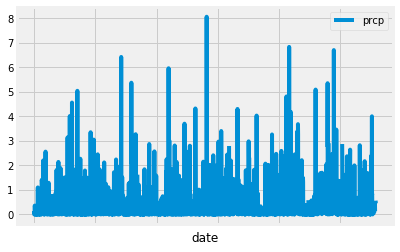

In [40]:
sorted_df.plot()

In [ ]:
plt.hist(high_temp_query, bin=12)
plt.tight_layout()

In [37]:
high_temp_query = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.station >= query_date).all()
high_temp_query

[(70.0),
 (62.0),
 (74.0),
 (75.0),
 (74.0),
 (76.0),
 (69.0),
 (66.0),
 (70.0),
 (75.0),
 (64.0),
 (60.0),
 (61.0),
 (68.0),
 (64.0),
 (66.0),
 (67.0),
 (70.0),
 (67.0),
 (67.0),
 (69.0),
 (60.0),
 (75.0),
 (75.0),
 (65.0),
 (75.0),
 (69.0),
 (67.0),
 (66.0),
 (69.0),
 (72.0),
 (67.0),
 (65.0),
 (64.0),
 (67.0),
 (67.0),
 (68.0),
 (69.0),
 (66.0),
 (69.0),
 (61.0),
 (71.0),
 (70.0),
 (70.0),
 (66.0),
 (71.0),
 (61.0),
 (68.0),
 (67.0),
 (62.0),
 (65.0),
 (69.0),
 (63.0),
 (62.0),
 (61.0),
 (64.0),
 (72.0),
 (68.0),
 (68.0),
 (68.0),
 (71.0),
 (69.0),
 (65.0),
 (67.0),
 (71.0),
 (70.0),
 (69.0),
 (69.0),
 (70.0),
 (69.0),
 (70.0),
 (73.0),
 (74.0),
 (67.0),
 (68.0),
 (64.0),
 (65.0),
 (68.0),
 (68.0),
 (72.0),
 (67.0),
 (64.0),
 (71.0),
 (70.0),
 (72.0),
 (73.0),
 (74.0),
 (69.0),
 (71.0),
 (72.0),
 (71.0),
 (74.0),
 (73.0),
 (71.0),
 (71.0),
 (69.0),
 (69.0),
 (72.0),
 (68.0),
 (75.0),
 (69.0),
 (65.0),
 (68.0),
 (65.0),
 (66.0),
 (64.0),
 (69.0),
 (69.0),
 (70.0),
 (69.0),
 (69.0),
 

In [32]:
begin_trip = dt.date(2017, 7, 29) - dt.timedelta(days=362)
end_trip = dt.date(2017, 8, 3) - dt.timedelta(days=362)
#begin_trip
end_trip

datetime.date(2016, 8, 6)

In [ ]:
import numpy as np

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

from flask import Flask, jsonify


engine = create_engine("sqlite://Resources/hawaii.sqlite")


Base = automap_base()

Base.prepare(engine, reflect=True)

Measurement = Base.classes.measurement
Station = Base.classes.station

pcrp_dict = {"date": "pcrp"}
station_dict = {"station": "name"}
session = Session(engine)


app = Flask(__name__)


@app.route("/")
def home():
    """List all available api routes."""
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/prcp<br/>"
        f"/api/v1.0/station<br/>"
        f"/api/v1.0/tobs"
        f"/api/v1.0/date"
        f"/api/v1.0/latitude"
        f"/api/v1.0/longitudee"
        f"/api/v1.0/elevation "
        f"`/api/v1.0/<start>"
        f" /api/v1.0/<start>/<end>"
    )

@app.route("/api/v1.0/prcp")
def pcrp():
    return jsonify(pcrp_dict)

@app.route("/api/v1.0/station")
def station():
    return jsonify(station_dict)

@app.route("/api/v1.0/tobs")
def tobs():
   
    results = session.query(Measurement.tobs).all()

    temps= []
    for temp in temps:
        pcrp_dict = {}
        pcrp_dict["tobs"] = measurement.date >="2017-08-23"
        temps.append(pcrp_dict)

    return jsonify(temps)

if __name__ == "__main__":
    app.run(debug=True)
